In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import itertools
import random
random.seed(108448)
from scipy.stats import poisson

#%pip install gurobipy
import gurobipy as gp
from gurobipy import GRB

Data generation

In [47]:
#Define the number of elements in each set I, J, K
i_num = 14
k_num = 5
j_num = 500 #Without I and K, so real j_num_real = j_num + i_num + k_num

#Define empty data frames
I = pd.DataFrame(columns = ['Point number', 'Latitude', 'Longitude'])
J = pd.DataFrame(columns = ['Point number', 'Latitude', 'Longitude'])
K = pd.DataFrame(columns = ['Point number', 'Latitude', 'Longitude'])


In [48]:
#Define sets of I, J, K, where J contains I and K

for i in range(i_num):
    I.loc[i, 'Point number'] = 'i'+ str(i)
    I.loc[i, 'Latitude'] = round(random.uniform(0, 5000), 0)
    I.loc[i, 'Longitude'] = round(random.uniform(0, 5000), 0)

I.index = I['Point number']
    
    
for k in range(k_num):
    K.loc[k, 'Point number'] = 'k'+ str(k)
    K.loc[k, 'Latitude'] = round(random.uniform(0, 5000), 0)
    K.loc[k, 'Longitude'] = round(random.uniform(0, 5000), 0)

K.index = K['Point number']


for j in range(j_num):
    J.loc[j, 'Point number'] = 'j'+ str(j)
    J.loc[j, 'Latitude'] = round(random.uniform(0, 5000), 0)
    J.loc[j, 'Longitude'] = round(random.uniform(0, 5000), 0)

J.index = J['Point number'] 
J = pd.concat([J, K, I], axis = 0) #Include K to J
J

,Point number,Latitude,Longitude
Point number,,,
j0,j0,489.0,453.0
j1,j1,4254.0,1414.0
j2,j2,4289.0,1417.0
j3,j3,1344.0,2427.0
j4,j4,4490.0,2623.0
...,...,...,...
i9,i9,848.0,4160.0
i10,i10,2136.0,3936.0
i11,i11,2969.0,1617.0


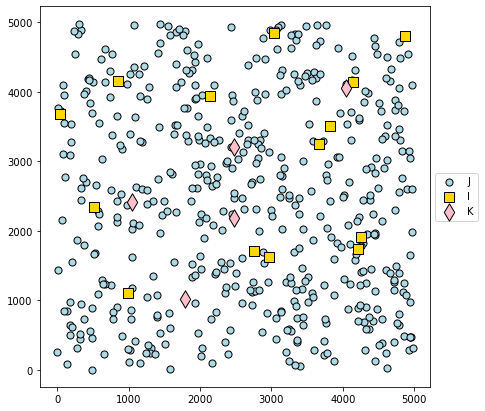

In [49]:
axs, fig = plt.subplots(1, 1, figsize = (7, 7))

fig.scatter(J['Latitude'], J['Longitude'], color = 'lightblue', edgecolors = 'black',
            marker = 'o', s = 50, label = 'J')
fig.scatter(I['Latitude'], I['Longitude'], color = 'gold', edgecolors = 'black',
            marker = 's', s = 100, label = 'I')
fig.scatter(K['Latitude'], K['Longitude'], color = 'pink', edgecolors = 'black',
            marker = 'd', s = 150, label = 'K')
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [50]:
# from pathlib import Path
# import pandas as pd
# import geopandas as gpd
# import shapely
# #%pip install folium matplotlib mapclassify
# import folium
# import matplotlib

# # Doctor's coordinates
# doctors = {'Latitude' : [48.56500199216254, 48.5705, 48.575], 'Longitude' : [13.433214775837387, 13.436, 13.44]}
# df = pd.DataFrame(doctors)
# df

# # create geodataframe, NB CRS
# geo_df = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df["Latitude"], df["Longitude"]), crs="epsg:4386")


# with open('Polygon Passau.txt', 'r') as file:
#     # Read the contents of the file into a string
#     polygon_str = file.read()

# # Now file_contents contains the contents of the file as a string
# passau_poly = shapely.wkt.loads(polygon_str)


# passau_gdf = gpd.GeoDataFrame(geometry=[passau_poly], crs="epsg:4326")
# passau_map = folium.Map(location=[48.565, 13.433], zoom_start=12)
# folium.GeoJson(passau_gdf).add_to(passau_map)

# geo_doctors = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df["Latitude"], df["Longitude"]), crs="epsg:4326")

# for idx, row in geo_doctors.iterrows():
#     folium.Marker([row['Latitude'], row['Longitude']], icon=folium.Icon(icon='circle', prefix='fa', color='blue'), 
#                   icon_size=(0.5, 0.5)).add_to(passau_map)

# lines = []
# for i in range(len(geo_doctors) - 1):
#     point1 = geo_doctors.iloc[i].geometry
#     point2 = geo_doctors.iloc[i + 1].geometry
#     lines.append([point1.coords[0], point2.coords[0]])

# folium.PolyLine(lines, color='blue').add_to(passau_map)



# passau_map

In [51]:
#Define constants

B = 90 * 60 #battery load: seconds of travel
S = 17 * (10 * 60) #meters of service time
alpha = 14760 + 500 #euro

beta = {}
for j in J.index:
    if j.startswith('j'):
        beta[j] = 400000
    else:
        beta[j] = 300000
        
gamma = 0.0045 / 1000 # variable cost in euro per m
        
q_j = {j: 50 for j in J.index}

up_bound = 12
mu = {i : int(round(random.uniform(0, up_bound), 0)) for i in I.index}

mu

{'i0': 11,
 'i1': 9,
 'i2': 4,
 'i3': 2,
 'i4': 6,
 'i5': 10,
 'i6': 5,
 'i7': 2,
 'i8': 10,
 'i9': 10,
 'i10': 5,
 'i11': 0,
 'i12': 8,
 'i13': 11}

Deterministic model

In [52]:
theta_det = {}
for n in I.index:
    theta_det[n] = list(poisson.rvs(mu[n], size = 1))[0]
theta_det

{'i0': 8,
 'i1': 9,
 'i2': 3,
 'i3': 2,
 'i4': 5,
 'i5': 12,
 'i6': 6,
 'i7': 1,
 'i8': 14,
 'i9': 7,
 'i10': 4,
 'i11': 0,
 'i12': 8,
 'i13': 10}

In [53]:
#Define distance matrices

def distance(point1, PointsSet1, point2, PointsSet2):
    c1 = np.array((PointsSet1.loc[point1, 'Latitude'], PointsSet1.loc[point1, 'Longitude']))
    c2 = np.array((PointsSet2.loc[point2, 'Latitude'], PointsSet2.loc[point2, 'Longitude']))
    return np.linalg.norm(c1-c2)

dist_JI = {(c1, c2): distance(c1, J, c2, I)for c1, c2 in itertools.product(J.index, I.index)}
dist_IK = {(c1, c2): distance(c1, I, c2, K)for c1, c2 in itertools.product(I.index, K.index)}
dist_KJ = {(c1, c2): distance(c1, K, c2, J)for c1, c2 in itertools.product(K.index, J.index)}
 
dist_KJ


{('k0', 'j0'): 5053.08974786714,
 ('k0', 'j1'): 2643.756796681571,
 ('k0', 'j2'): 2643.846440321374,
 ('k0', 'j3'): 3145.4584721467872,
 ('k0', 'j4'): 1495.6192697341125,
 ('k0', 'j5'): 2330.028755187369,
 ('k0', 'j6'): 4573.794048708359,
 ('k0', 'j7'): 3777.876784650341,
 ('k0', 'j8'): 3691.7034008706605,
 ('k0', 'j9'): 3142.82070758101,
 ('k0', 'j10'): 3649.1064659721837,
 ('k0', 'j11'): 4146.483449864475,
 ('k0', 'j12'): 3199.4357315001657,
 ('k0', 'j13'): 3841.313447246918,
 ('k0', 'j14'): 2225.29211565583,
 ('k0', 'j15'): 1194.9510450223474,
 ('k0', 'j16'): 1436.2040245034825,
 ('k0', 'j17'): 4080.246193552541,
 ('k0', 'j18'): 3334.622167502639,
 ('k0', 'j19'): 1290.4747188534923,
 ('k0', 'j20'): 1980.0113636037547,
 ('k0', 'j21'): 3390.25382530571,
 ('k0', 'j22'): 2903.7472341786224,
 ('k0', 'j23'): 5139.477210767648,
 ('k0', 'j24'): 1058.218313959837,
 ('k0', 'j25'): 1054.9587669667474,
 ('k0', 'j26'): 3795.2634954637865,
 ('k0', 'j27'): 3852.8011887456637,
 ('k0', 'j28'): 3733.

In [54]:
#Define set L
L = list()
for k, j in itertools.product(K.index, J.index):
    if dist_KJ[(k, j)] <= 0.5*B:
        L.append((k, j))
        
L

[('k0', 'j1'),
 ('k0', 'j2'),
 ('k0', 'j4'),
 ('k0', 'j5'),
 ('k0', 'j14'),
 ('k0', 'j15'),
 ('k0', 'j16'),
 ('k0', 'j19'),
 ('k0', 'j20'),
 ('k0', 'j24'),
 ('k0', 'j25'),
 ('k0', 'j29'),
 ('k0', 'j30'),
 ('k0', 'j31'),
 ('k0', 'j32'),
 ('k0', 'j35'),
 ('k0', 'j36'),
 ('k0', 'j37'),
 ('k0', 'j42'),
 ('k0', 'j47'),
 ('k0', 'j49'),
 ('k0', 'j55'),
 ('k0', 'j57'),
 ('k0', 'j63'),
 ('k0', 'j65'),
 ('k0', 'j66'),
 ('k0', 'j67'),
 ('k0', 'j69'),
 ('k0', 'j70'),
 ('k0', 'j71'),
 ('k0', 'j73'),
 ('k0', 'j74'),
 ('k0', 'j75'),
 ('k0', 'j76'),
 ('k0', 'j80'),
 ('k0', 'j88'),
 ('k0', 'j90'),
 ('k0', 'j91'),
 ('k0', 'j94'),
 ('k0', 'j97'),
 ('k0', 'j98'),
 ('k0', 'j99'),
 ('k0', 'j101'),
 ('k0', 'j102'),
 ('k0', 'j103'),
 ('k0', 'j104'),
 ('k0', 'j109'),
 ('k0', 'j110'),
 ('k0', 'j112'),
 ('k0', 'j113'),
 ('k0', 'j116'),
 ('k0', 'j121'),
 ('k0', 'j122'),
 ('k0', 'j123'),
 ('k0', 'j124'),
 ('k0', 'j126'),
 ('k0', 'j129'),
 ('k0', 'j131'),
 ('k0', 'j134'),
 ('k0', 'j135'),
 ('k0', 'j136'),
 ('k0', '

In [55]:
#Define sets M_kj

M_kj = {}
M_interim = []

for (k, j) in L:
    for i in I.index:
        if dist_JI[j, i] <= S:
            if dist_JI[j, i] + dist_IK[i, k] + dist_KJ[k, j] <= B:
                M_interim.append(i)
    M_kj[(k, j)] = M_interim
    M_interim = []

M_kj_final = {key : val for key, val in M_kj.items() if val != []}  

KJ_feas = list(M_kj_final.keys())
M_kj_final


{('k0', 'j1'): ['i0', 'i4', 'i5'],
 ('k0', 'j2'): ['i0', 'i4', 'i5'],
 ('k0', 'j4'): ['i0', 'i3', 'i4', 'i5', 'i12', 'i13'],
 ('k0', 'j5'): ['i3', 'i5', 'i10', 'i12'],
 ('k0', 'j14'): ['i0', 'i3', 'i4', 'i5', 'i12'],
 ('k0', 'j15'): ['i0',
  'i1',
  'i3',
  'i4',
  'i5',
  'i7',
  'i10',
  'i11',
  'i12',
  'i13'],
 ('k0', 'j16'): ['i0',
  'i1',
  'i3',
  'i4',
  'i5',
  'i7',
  'i10',
  'i11',
  'i12',
  'i13'],
 ('k0', 'j19'): ['i3', 'i5', 'i7', 'i10', 'i12', 'i13'],
 ('k0', 'j20'): ['i0', 'i3', 'i4', 'i5', 'i12'],
 ('k0', 'j24'): ['i3', 'i5', 'i7', 'i10', 'i12', 'i13'],
 ('k0', 'j25'): ['i3', 'i5', 'i7', 'i10', 'i12', 'i13'],
 ('k0', 'j29'): ['i3', 'i5'],
 ('k0', 'j30'): ['i0', 'i3', 'i4', 'i5', 'i12'],
 ('k0', 'j31'): ['i3', 'i5', 'i12'],
 ('k0', 'j32'): ['i0', 'i3', 'i4', 'i5', 'i12'],
 ('k0', 'j35'): ['i3', 'i5', 'i7', 'i10', 'i12'],
 ('k0', 'j36'): ['i0', 'i3', 'i4', 'i5', 'i7', 'i10', 'i12', 'i13'],
 ('k0', 'j37'): ['i3', 'i4', 'i5', 'i7', 'i12', 'i13'],
 ('k0', 'j42'): ['i3', 

In [56]:
#Define sets N_i

N_i = {}
N_interim = []

for i in I.index:
    for (k, j) in L:
        if dist_JI[j, i] <= S:
            if dist_JI[j, i] + dist_IK[i, k] + dist_KJ[k, j] <= B:
                N_interim.append((k, j))
    N_i[i] = N_interim
    N_interim = []
    
N_i_final = {key : val for key, val in N_i.items() if val != []}   
 
I_feas = list(N_i_final.keys())
N_i_final

{'i0': [('k0', 'j1'),
  ('k0', 'j2'),
  ('k0', 'j4'),
  ('k0', 'j14'),
  ('k0', 'j15'),
  ('k0', 'j16'),
  ('k0', 'j20'),
  ('k0', 'j30'),
  ('k0', 'j32'),
  ('k0', 'j36'),
  ('k0', 'j47'),
  ('k0', 'j49'),
  ('k0', 'j65'),
  ('k0', 'j66'),
  ('k0', 'j73'),
  ('k0', 'j76'),
  ('k0', 'j80'),
  ('k0', 'j97'),
  ('k0', 'j99'),
  ('k0', 'j101'),
  ('k0', 'j102'),
  ('k0', 'j110'),
  ('k0', 'j112'),
  ('k0', 'j113'),
  ('k0', 'j123'),
  ('k0', 'j138'),
  ('k0', 'j143'),
  ('k0', 'j155'),
  ('k0', 'j169'),
  ('k0', 'j171'),
  ('k0', 'j174'),
  ('k0', 'j175'),
  ('k0', 'j183'),
  ('k0', 'j184'),
  ('k0', 'j189'),
  ('k0', 'j208'),
  ('k0', 'j218'),
  ('k0', 'j220'),
  ('k0', 'j226'),
  ('k0', 'j235'),
  ('k0', 'j239'),
  ('k0', 'j241'),
  ('k0', 'j243'),
  ('k0', 'j248'),
  ('k0', 'j250'),
  ('k0', 'j251'),
  ('k0', 'j257'),
  ('k0', 'j264'),
  ('k0', 'j268'),
  ('k0', 'j269'),
  ('k0', 'j278'),
  ('k0', 'j282'),
  ('k0', 'j283'),
  ('k0', 'j284'),
  ('k0', 'j288'),
  ('k0', 'j293'),
  ('k0',

In [73]:
model_det = gp.Model('Deterministic model without relaxation')

x_ikj = model_det.addVars(I_feas, KJ_feas, vtype = GRB.INTEGER, name = 'x_ikj')
y_j = model_det.addVars(J.index, vtype = GRB.BINARY, name = 'y_j')

In [74]:
model_det.addConstrs((gp.quicksum(x_ikj[i, k, j] for (k, j) in N_i_final[i]) >= theta_det[i] for i in I_feas), name = 'c2')
model_det.addConstrs((gp.quicksum(x_ikj[i, k, j] for i in M_kj_final[(k, j)]) <= q_j[j] * y_j[j] for (k, j) in KJ_feas), name = 'c4')
model_det.addConstrs(((dist_JI[(j, i)] + dist_IK[(i, k)] + dist_KJ[(k, j)]) * y_j[j] <= B
                  for (k, j) in N_i_final[i] for i in M_kj_final[(k, j)]), name = 'c5')
model_det.addConstrs((dist_JI[(j, i)] * y_j[j] <= S for (k, j) in N_i_final[i] for i in M_kj_final[(k, j)]), name = 'c6')

{('k0', 'j4', 'i0'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j4', 'i3'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j4', 'i4'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j4', 'i5'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j4', 'i12'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j4', 'i13'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j15', 'i0'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j15', 'i1'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j15', 'i3'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j15', 'i4'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j15', 'i5'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j15', 'i7'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j15', 'i10'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j15', 'i11'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j15', 'i12'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j15', 'i13'): <gurobi.Constr *Awaiting Model Up

In [79]:
model_det.setObjective(alpha * gp.quicksum(x_ikj[i, k, j] for (k, j) in N_i_final[i] for i in I_feas) + gp.quicksum(beta[j] * y_j[j] for j in J.index) + gp.quicksum(gamma * (dist_JI[(j, i)] + dist_IK[(i, k)] + dist_KJ[(k, j)]) * y_j[j] for (k, j) in N_i_final[i] for i in I_feas), GRB.MINIMIZE)
model_det.optimize()

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i5-1145G7 @ 2.60GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 3463 rows, 23437 columns and 19268 nonzeros
Model fingerprint: 0x530641f5
Variable types: 0 continuous, 23437 integer (519 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+03]
  Objective range  [2e+04, 4e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+04]

Loaded MIP start from previous solve with objective 752600

Presolve removed 1995 rows and 16145 columns
Presolve time: 0.07s
Presolved: 1468 rows, 7292 columns, 15206 nonzeros
Variable types: 0 continuous, 7292 integer (615 binary)

Root relaxation: objective 2.972216e+05, 2061 iterations, 0.17 seconds (0.18 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd 

In [76]:
def ListSolution(model):
        nSolutions = model.SolCount
        print('Number of solutions found: ' + str(nSolutions))
        for e in range(nSolutions):
        #for iter2 in range(1):
                model.setParam(GRB.Param.SolutionNumber, e)
                print(e)
                print('%g ' % model.PoolObjVal, end='\n')
                for v in model.getVars():
                        if v.X > 0:
                                print ('%s %g' % (v.varName, v.X))
                                #print(v)
                print("\n")
                
        print("\n")
        
ListSolution(model_det)

Number of solutions found: 4
0
752600 
x_ikj[i0,k2,k2] 8
x_ikj[i1,k4,k2] 50
x_ikj[i2,k3,k2] 3
x_ikj[i3,k1,k0] 2
x_ikj[i4,k1,k2] 50
x_ikj[i5,k0,k2] 12
x_ikj[i6,k2,k2] 6
x_ikj[i7,k2,k0] 1
x_ikj[i8,k2,k2] 36
x_ikj[i9,k3,k2] 47
x_ikj[i10,k0,k2] 38
x_ikj[i10,k2,k0] 49
x_ikj[i12,k1,k0] 48
x_ikj[i13,k0,k0] 10
y_j[k0] 1
y_j[k2] 1


1
852600 
x_ikj[i0,k2,k2] 8
x_ikj[i1,k4,k2] 50
x_ikj[i2,k3,k2] 3
x_ikj[i3,k1,k0] 2
x_ikj[i4,k1,k2] 50
x_ikj[i5,k0,k2] 12
x_ikj[i6,k2,k2] 6
x_ikj[i7,k2,k0] 1
x_ikj[i8,k2,k2] 36
x_ikj[i9,k3,k2] 47
x_ikj[i10,k0,k2] 38
x_ikj[i10,k2,k0] 49
x_ikj[i12,k1,k0] 48
x_ikj[i13,k0,k0] 10
y_j[k0] 1
y_j[k2] 1


2
952600 
x_ikj[i0,k2,k2] 8
x_ikj[i1,k4,k2] 50
x_ikj[i2,k3,k2] 3
x_ikj[i3,k1,k0] 2
x_ikj[i4,k1,k2] 50
x_ikj[i5,k0,k2] 12
x_ikj[i6,k2,k2] 6
x_ikj[i7,k2,k0] 1
x_ikj[i8,k2,k2] 36
x_ikj[i9,k3,k2] 47
x_ikj[i10,k0,k2] 38
x_ikj[i10,k2,k0] 49
x_ikj[i12,k1,k0] 48
x_ikj[i13,k0,k0] 10
y_j[k0] 1
y_j[k2] 1


3
5.2526e+06 
x_ikj[i0,k2,k2] 8
x_ikj[i1,k4,k2] 50
x_ikj[i2,k3,k2] 3
x_ikj[i3,k1

In [77]:
def SolutionSummary(model):
    n = -1
    results = pd.DataFrame(columns = ['i', 'k', 'j', 'Number of drones'])
    for opt_sol in range(1):
        for v in model.getVars():
            if v.varName.startswith('x_ikj'):
                if v.X > 0:
                    n += 1
                    indices = v.varName[6:-1].split(',') #drop variable name and brackets and convert to a list of indices
                    results.loc[n, 'i'] = indices[0]
                    results.loc[n, 'k'] = indices[1]
                    results.loc[n, 'j'] = indices[2]
                    results.loc[n, 'Number of drones'] = int(v.X)
    results_doctors = results.groupby('i', as_index = False)['Number of drones'].sum()
    results_locations = results.groupby('j', as_index = False)['Number of drones'].sum()
    return results_doctors, results_locations

SolutionSummary(model_det)

(      i  Number of drones
 0    i0                 8
 1    i1                50
 2   i10                87
 3   i12                48
 4   i13                10
 5    i2                 3
 6    i3                 2
 7    i4                50
 8    i5                12
 9    i6                 6
 10   i7                 1
 11   i8                36
 12   i9                47,
     j  Number of drones
 0  k0               110
 1  k2               250)

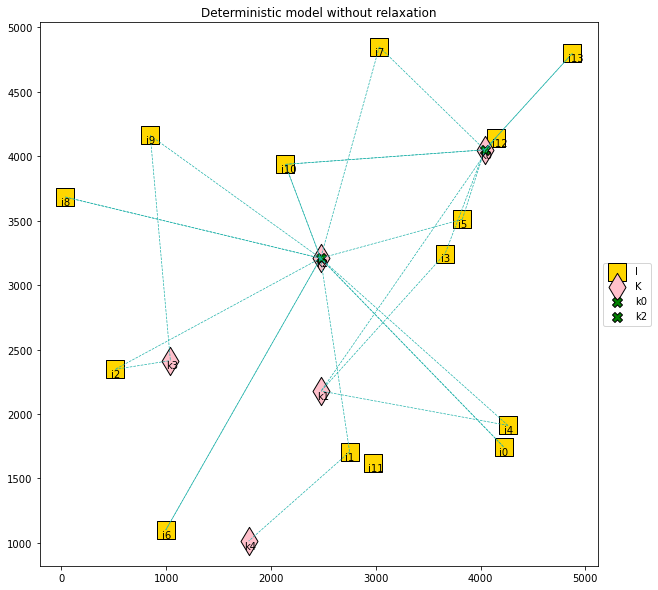

In [78]:
def SolutionGraph(I, K, J, model):
        
        axs, fig = plt.subplots(1, 1, figsize = (10, 10))
                
        fig.scatter(I['Latitude'], I['Longitude'], color = 'gold', edgecolors = 'black',
                                marker = 's', s = 300, label = 'I')
        for i in range (len(I.index)):
                fig.annotate(I.index[i], (I['Latitude'][i] - 40, I['Longitude'][i] - 60))
                
        fig.scatter(K['Latitude'], K['Longitude'], color = 'pink', edgecolors = 'black',
                                marker = 'd', s = 400, label = 'K')
        for k in range (len(K.index)):
                fig.annotate(K.index[k], (K['Latitude'][k] - 40, K['Longitude'][k] - 60))
        
        fig.set_title(model.ModelName)
        model.setParam(GRB.Param.SolutionNumber, 0)
        for v in model.getVars():
                if v.xn > 0:
                        if v.varName.startswith('x_ikj'):
                                indices_x = v.varName[6:-1].split(',') #drop variable name and brackets and convert to a list of indices
                                fig.plot((J.loc[indices_x[2], 'Latitude'], I.loc[indices_x[0], 'Latitude']),
                                        (J.loc[indices_x[2], 'Longitude'], I.loc[indices_x[0], 'Longitude']),
                                        color = 'lightseagreen', linestyle = "--", linewidth = 0.7)
                                fig.plot((I.loc[indices_x[0], 'Latitude'], K.loc[indices_x[1], 'Latitude']),
                                        (I.loc[indices_x[0], 'Longitude'], K.loc[indices_x[1], 'Longitude']),
                                        color = 'lightseagreen', linestyle = "--", linewidth = 0.7)
                                # fig.annotate(str(int(v.xn)), xy = ((K.loc[indices_x[1], 'Latitude'] + I.loc[indices_x[0], 'Latitude'])/2,
                                #                                 (K.loc[indices_x[1], 'Longitude'] + I.loc[indices_x[0], 'Longitude'])/2))
                                # fig.annotate(str(int(v.xn)), xy = ((J.loc[indices_x[2], 'Latitude'] + I.loc[indices_x[0], 'Latitude'])/2,
                                #                                 (J.loc[indices_x[2], 'Longitude'] + I.loc[indices_x[0], 'Longitude'])/2))
                        else:
                                index_y = v.varName[4:-1]
                                fig.scatter(J.loc[index_y, 'Latitude'], J.loc[index_y, 'Longitude'], color = 'green',
                                        edgecolors = 'black', s = 100, marker = 'X', label = index_y)
                fig.legend(loc = 'center left', bbox_to_anchor = (1, 0.5))
    

SolutionGraph(I, K, J, model_det)

In [ ]:
for v in model_det.getVars():
        if v.xn > 0:
            if v.varName.startswith('x_ikj'):
                indices_x = v.varName[6:-1].split(',')
indices_x

['i13', 'k0', 'k0']

Probabilistic model

In [ ]:
#Define constants and random variables

theta_ran_i = {}
for n in list(I.index):
    theta_ran_i[n] = poisson(mu[n])

p = 0.98

l_i = {}
for i in theta_ran_i.keys():
    l_i[i] = int(theta_ran_i[i].ppf(p))


g_i = {}
for i in theta_ran_i.keys():
    g_i[i] = mu[i] * 15

IG = []
for i in I.index:
    for g in range(1, g_i[i] + 1):
        IG.append((i, g))

I_feasG = []
for i in I_feas:
    for g in range(1, g_i[i] + 1):
        I_feasG.append((i, g))
        

h_ig = {}
for (i, g) in IG:
    h_ig[(i, g)] = math.log(theta_ran_i[i].cdf(l_i[i] + g)) - math.log(theta_ran_i[i].cdf(l_i[i] + g - 1))


phi = float(math.log(p) - sum(theta_ran_i[i].cdf(l_i[i]) for i in I_feas))

In [ ]:
model_prob = gp.Model('Probabilistic model without relaxation')

x_ikj = model_prob.addVars(I.index, L, vtype = GRB.INTEGER, name = 'x_ikj')
y_j = model_prob.addVars(J.index, vtype = GRB.BINARY, name = 'y_j')
z_ig = model_prob.addVars(IG, vtype = GRB.BINARY, name = 'z_ig')

In [ ]:
#Probabilistic constraints

model_prob.addConstr((gp.quicksum(h_ig[ig] * z_ig[ig] for ig in I_feasG)) >= phi, name = 'c15')
model_prob.addConstrs((gp.quicksum(x_ikj[i, k, j] for (k, j) in N_i[i]) == l_i[i] + gp.quicksum(z_ig) for (i, g) in I_feasG), name = 'c16')

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


{('i0', 1): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 2): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 3): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 4): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 5): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 6): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 7): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 8): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 9): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 10): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 11): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 12): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 13): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 14): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 15): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 16): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 17): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 18): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 19): <gurobi.Constr *Awaiting

In [ ]:
#Same constraints as in the deterministic model

model_prob.addConstrs((gp.quicksum(x_ikj[i, k, j] for i in M_kj[(k, j)]) <= q_j[j] * y_j[j] for (k, j) in KJ_feas), name = 'c17')
model_prob.addConstrs(((dist_JI[(j, i)] + dist_IK[(i, k)] + dist_KJ[(k, j)]) * y_j[j] <= B
                  for (k, j) in N_i[i] for i in M_kj[(k, j)]), name = 'c18')
model_prob.addConstrs((dist_JI[(j, i)] * y_j[j] <= S for (k, j) in N_i[i] for i in M_kj[(k, j)]), name = 'c19')

{('k0', 'j4', 'i0'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j4', 'i3'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j4', 'i4'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j4', 'i5'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j4', 'i12'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j4', 'i13'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j15', 'i0'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j15', 'i1'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j15', 'i3'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j15', 'i4'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j15', 'i5'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j15', 'i7'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j15', 'i10'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j15', 'i11'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j15', 'i12'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j15', 'i13'): <gurobi.Constr *Awaiting Model Up

In [ ]:
model_prob.setObjective(alpha * gp.quicksum(x_ikj[i, k, j] for (k, j) in N_i[i] for i in I.index) + gp.quicksum(beta[j] * y_j[j] for j in J.index) + gamma * gp.quicksum((dist_JI[(j, i)] + dist_IK[(i, k)] + dist_KJ[(k, j)]) * y_j[j] for (k, j) in N_i[i] for i in I.index), GRB.MINIMIZE)
model_prob.optimize()

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i5-1145G7 @ 2.60GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 4845 rows, 25868 columns and 2661509 nonzeros
Model fingerprint: 0x2b77a42c
Variable types: 0 continuous, 25868 integer (1914 binary)
Coefficient statistics:
  Matrix range     [1e-13, 5e+03]
  Objective range  [2e+04, 4e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e+00, 1e+04]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Found heuristic solution: objective 5740921.4428
Presolve removed 3196 rows and 18388 columns
Presolve time: 2.04s
Presolved: 1649 rows, 7480 columns, 15603 nonzeros
Variable types: 0 continuous, 7480 integer (502 binary)
Found heuristic solution: objective 5710401.4428

Root relaxation: objective 5.171417e+05, 4457 iterations, 0.21 seconds 

In [ ]:
ListSolution(model_prob)

Number of solutions found: 4
0
874680 
x_ikj[i0,k1,k2] 7
x_ikj[i0,k2,k2] 11
x_ikj[i1,k4,k2] 16
x_ikj[i2,k1,k2] 9
x_ikj[i3,k2,k0] 5
x_ikj[i4,k2,k2] 12
x_ikj[i5,k2,k0] 17
x_ikj[i6,k2,k2] 10
x_ikj[i7,k2,k0] 5
x_ikj[i8,k2,k2] 17
x_ikj[i9,k3,k2] 17
x_ikj[i10,k2,k0] 10
x_ikj[i12,k1,k0] 1
x_ikj[i12,k2,k0] 13
x_ikj[i13,k0,k0] 18
y_j[k0] 1
y_j[k2] 1


1
1.17468e+06 
x_ikj[i0,k1,k2] 7
x_ikj[i0,k2,k2] 11
x_ikj[i1,k4,k2] 16
x_ikj[i2,k1,k2] 9
x_ikj[i3,k2,k0] 5
x_ikj[i4,k2,k2] 12
x_ikj[i5,k2,k0] 17
x_ikj[i6,k2,k2] 10
x_ikj[i7,k2,k0] 5
x_ikj[i8,k2,k2] 17
x_ikj[i9,k3,k2] 17
x_ikj[i10,k2,k0] 10
x_ikj[i12,k1,k0] 1
x_ikj[i12,k2,k0] 13
x_ikj[i13,k0,k0] 18
y_j[k0] 1
y_j[k2] 1


2
5.7104e+06 
x_ikj[i0,k1,k2] 7
x_ikj[i0,k2,k2] 11
x_ikj[i1,k4,k2] 16
x_ikj[i2,k1,k2] 9
x_ikj[i3,k2,k0] 5
x_ikj[i4,k2,k2] 12
x_ikj[i5,k2,k0] 17
x_ikj[i6,k2,k2] 10
x_ikj[i7,k2,k0] 5
x_ikj[i8,k2,k2] 17
x_ikj[i9,k3,k2] 17
x_ikj[i10,k2,k0] 10
x_ikj[i12,k1,k0] 1
x_ikj[i12,k2,k0] 13
x_ikj[i13,k0,k0] 18
y_j[k0] 1
y_j[k2] 1


3
5.74092e+06 

In [ ]:
SolutionSummary(model_prob)

(      i  Number of drones
 0    i0                18
 1    i1                16
 2   i10                10
 3   i12                14
 4   i13                18
 5    i2                 9
 6    i3                 5
 7    i4                12
 8    i5                17
 9    i6                10
 10   i7                 5
 11   i8                17
 12   i9                17,
     j  Number of drones
 0  k0                69
 1  k2                99)

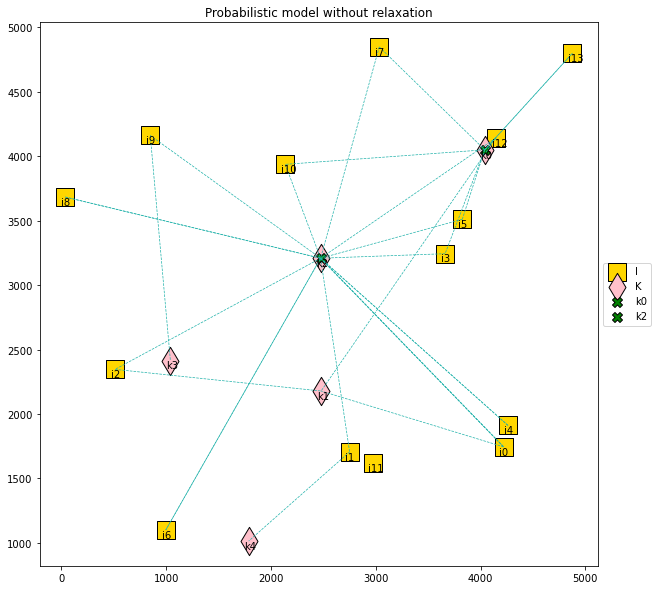

In [ ]:
SolutionGraph(I, K, J, model_prob)

Probabilistic model with relaxed constraints

In [ ]:
#Redefine set L
L = list()
for k, j in itertools.product(K.index, J.index):
    if dist_KJ[(k, j)] <= B:
        L.append((k, j))
        
L

[('k0', 'j0'),
 ('k0', 'j1'),
 ('k0', 'j2'),
 ('k0', 'j3'),
 ('k0', 'j4'),
 ('k0', 'j5'),
 ('k0', 'j6'),
 ('k0', 'j7'),
 ('k0', 'j8'),
 ('k0', 'j9'),
 ('k0', 'j10'),
 ('k0', 'j11'),
 ('k0', 'j12'),
 ('k0', 'j13'),
 ('k0', 'j14'),
 ('k0', 'j15'),
 ('k0', 'j16'),
 ('k0', 'j17'),
 ('k0', 'j18'),
 ('k0', 'j19'),
 ('k0', 'j20'),
 ('k0', 'j21'),
 ('k0', 'j22'),
 ('k0', 'j23'),
 ('k0', 'j24'),
 ('k0', 'j25'),
 ('k0', 'j26'),
 ('k0', 'j27'),
 ('k0', 'j28'),
 ('k0', 'j29'),
 ('k0', 'j30'),
 ('k0', 'j31'),
 ('k0', 'j32'),
 ('k0', 'j33'),
 ('k0', 'j34'),
 ('k0', 'j35'),
 ('k0', 'j36'),
 ('k0', 'j37'),
 ('k0', 'j38'),
 ('k0', 'j39'),
 ('k0', 'j40'),
 ('k0', 'j41'),
 ('k0', 'j42'),
 ('k0', 'j43'),
 ('k0', 'j44'),
 ('k0', 'j45'),
 ('k0', 'j46'),
 ('k0', 'j47'),
 ('k0', 'j48'),
 ('k0', 'j49'),
 ('k0', 'j50'),
 ('k0', 'j51'),
 ('k0', 'j52'),
 ('k0', 'j53'),
 ('k0', 'j54'),
 ('k0', 'j55'),
 ('k0', 'j56'),
 ('k0', 'j57'),
 ('k0', 'j58'),
 ('k0', 'j59'),
 ('k0', 'j60'),
 ('k0', 'j61'),
 ('k0', 'j62'),
 (

In [ ]:
#Redefine sets M_kj

M_kj = {}
M_interim = []

for (k, j) in L:
    for i in I.index:
        if dist_JI[j, i] <= S:
            if dist_JI[j, i] + dist_IK[i, k] <= B:
                M_interim.append(i)
    M_kj[(k, j)] = M_interim
    M_interim = []

M_kj_interim = {key : val for key, val in M_kj.items() if val != []}  

KJ_feas = list(M_kj_interim.keys())
KJ_feas

[('k0', 'j0'),
 ('k0', 'j1'),
 ('k0', 'j2'),
 ('k0', 'j3'),
 ('k0', 'j4'),
 ('k0', 'j5'),
 ('k0', 'j6'),
 ('k0', 'j7'),
 ('k0', 'j8'),
 ('k0', 'j9'),
 ('k0', 'j10'),
 ('k0', 'j11'),
 ('k0', 'j12'),
 ('k0', 'j13'),
 ('k0', 'j14'),
 ('k0', 'j15'),
 ('k0', 'j16'),
 ('k0', 'j17'),
 ('k0', 'j18'),
 ('k0', 'j19'),
 ('k0', 'j20'),
 ('k0', 'j21'),
 ('k0', 'j22'),
 ('k0', 'j23'),
 ('k0', 'j24'),
 ('k0', 'j25'),
 ('k0', 'j26'),
 ('k0', 'j27'),
 ('k0', 'j28'),
 ('k0', 'j29'),
 ('k0', 'j30'),
 ('k0', 'j31'),
 ('k0', 'j32'),
 ('k0', 'j33'),
 ('k0', 'j34'),
 ('k0', 'j35'),
 ('k0', 'j36'),
 ('k0', 'j37'),
 ('k0', 'j38'),
 ('k0', 'j39'),
 ('k0', 'j40'),
 ('k0', 'j41'),
 ('k0', 'j42'),
 ('k0', 'j43'),
 ('k0', 'j44'),
 ('k0', 'j45'),
 ('k0', 'j46'),
 ('k0', 'j47'),
 ('k0', 'j48'),
 ('k0', 'j49'),
 ('k0', 'j50'),
 ('k0', 'j51'),
 ('k0', 'j52'),
 ('k0', 'j53'),
 ('k0', 'j54'),
 ('k0', 'j55'),
 ('k0', 'j56'),
 ('k0', 'j57'),
 ('k0', 'j58'),
 ('k0', 'j59'),
 ('k0', 'j60'),
 ('k0', 'j61'),
 ('k0', 'j62'),
 (

In [ ]:
#Redefine sets N_i

N_i = {}
N_interim = []

for i in I.index:
    for (k, j) in L:
        if dist_JI[j, i] <= S:
            if dist_JI[j, i] + dist_IK[i, k] <= B:
                N_interim.append((k, j))
    N_i[i] = N_interim
    N_interim = []
    
N_i_interim = {key : val for key, val in N_i.items() if val != []}   
 
I_feas = list(N_i_interim.keys())

In [ ]:
#Redefine constants and random variables


I_feasG = []
for i in I_feas:
    for g in range(1, g_i[i] + 1):
        I_feasG.append((i, g))

In [ ]:
model_prob_rel = gp.Model('Probabilistic model with relaxation')

x_ikj = model_prob_rel.addVars(I.index, L, vtype = GRB.INTEGER, name = 'x_ikj')
y_j = model_prob_rel.addVars(J.index, vtype = GRB.BINARY, name = 'y_j')
z_ig = model_prob_rel.addVars(IG, vtype = GRB.BINARY, name = 'z_ig')

In [ ]:
model_prob_rel.addConstr((gp.quicksum(h_ig[ig] * z_ig[ig] for ig in I_feasG)) >= phi, name = 'c15')
model_prob_rel.addConstrs((gp.quicksum(x_ikj[i, k, j] for (k, j) in N_i[i]) == l_i[i] + gp.quicksum(z_ig) for (i, g) in I_feasG), name = 'c16')
model_prob_rel.addConstrs((gp.quicksum(x_ikj[i, k, j] for i in M_kj[(k, j)]) <= q_j[j] * y_j[j] for (k, j) in KJ_feas), name = 'c17')



model_prob_rel.addConstrs(((dist_JI[(j, i)] + dist_IK[(i, k)]) * y_j[j] <= B
                  for (k, j) in N_i[i] for i in M_kj[(k, j)]), name = 'c18')


model_prob_rel.addConstrs((dist_JI[(j, i)] * y_j[j] <= S for (k, j) in N_i[i] for i in M_kj[(k, j)]), name = 'c20')




Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


{('k0', 'j1', 'i0'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j1', 'i1'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j1', 'i3'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j1', 'i4'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j1', 'i5'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j1', 'i7'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j1', 'i10'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j1', 'i11'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j1', 'i12'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j1', 'i13'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j2', 'i0'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j2', 'i1'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j2', 'i3'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j2', 'i4'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j2', 'i5'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j2', 'i7'): <gurobi.Constr *Awaiting Model Update*>,
 ('k

In [ ]:
model_prob_rel.setObjective(alpha * gp.quicksum(x_ikj[i, k, j] for (k, j) in N_i[i] for i in I.index) + gp.quicksum(beta[j] * y_j[j] for j in J.index) + gamma * gp.quicksum((dist_JI[(j, i)] + dist_IK[(i, k)] + dist_KJ[(k, j)]) * y_j[j] for (k, j) in N_i[i] for i in I.index), GRB.MINIMIZE)
model_prob_rel.optimize()

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i5-1145G7 @ 2.60GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 15032 rows, 38216 columns and 4089290 nonzeros
Model fingerprint: 0x0d81c980
Variable types: 0 continuous, 38216 integer (1914 binary)
Coefficient statistics:
  Matrix range     [1e-13, 5e+03]
  Objective range  [2e+04, 4e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e+00, 1e+04]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Found heuristic solution: objective 5779885.1306
Presolve removed 12427 rows and 17081 columns
Presolve time: 2.33s
Presolved: 2605 rows, 21135 columns, 43835 nonzeros
Variable types: 0 continuous, 21135 integer (519 binary)
Found heuristic solution: objective 5734105.1306

Root relaxation: objective 4.762801e+05, 8280 iterations, 1.00 seco

In [ ]:
ListSolution(model_prob_rel)

Number of solutions found: 5
0
574680 
x_ikj[i0,k1,k2] 18
x_ikj[i1,k4,k2] 16
x_ikj[i2,k2,k2] 9
x_ikj[i3,k1,k2] 3
x_ikj[i3,k4,k2] 2
x_ikj[i4,k1,k2] 12
x_ikj[i5,k2,k2] 12
x_ikj[i5,k4,k2] 5
x_ikj[i6,k3,k2] 10
x_ikj[i7,k3,k2] 5
x_ikj[i8,k1,k2] 17
x_ikj[i9,k4,k2] 17
x_ikj[i10,k4,k2] 10
x_ikj[i12,k2,k2] 14
x_ikj[i13,k0,k2] 18
y_j[k2] 1


1
874683 
x_ikj[i0,k1,k2] 18
x_ikj[i1,k4,k2] 16
x_ikj[i2,k2,k2] 9
x_ikj[i3,k1,k2] 3
x_ikj[i3,k4,k2] 2
x_ikj[i4,k1,k2] 12
x_ikj[i5,k2,k2] 12
x_ikj[i5,k4,k2] 5
x_ikj[i6,k3,k2] 10
x_ikj[i7,k3,k2] 5
x_ikj[i8,k1,k2] 17
x_ikj[i9,k4,k2] 17
x_ikj[i10,k4,k2] 10
x_ikj[i12,k2,k2] 14
x_ikj[i13,k0,k2] 18
y_j[k2] 1


2
1.17468e+06 
x_ikj[i0,k1,k2] 18
x_ikj[i1,k4,k2] 16
x_ikj[i2,k2,k2] 9
x_ikj[i3,k1,k2] 3
x_ikj[i3,k4,k2] 2
x_ikj[i4,k1,k2] 12
x_ikj[i5,k2,k2] 12
x_ikj[i5,k4,k2] 5
x_ikj[i6,k3,k2] 10
x_ikj[i7,k3,k2] 5
x_ikj[i8,k1,k2] 17
x_ikj[i9,k4,k2] 17
x_ikj[i10,k4,k2] 10
x_ikj[i12,k2,k2] 14
x_ikj[i13,k0,k2] 18
y_j[k2] 1


3
5.73411e+06 
x_ikj[i0,k1,k2] 18
x_ikj[i1,k4,k2] 1

In [ ]:
SolutionSummary(model_prob_rel)

(      i  Number of drones
 0    i0                18
 1    i1                16
 2   i10                10
 3   i12                14
 4   i13                18
 5    i2                 9
 6    i3                 5
 7    i4                12
 8    i5                17
 9    i6                10
 10   i7                 5
 11   i8                17
 12   i9                17,
     j  Number of drones
 0  k2               168)

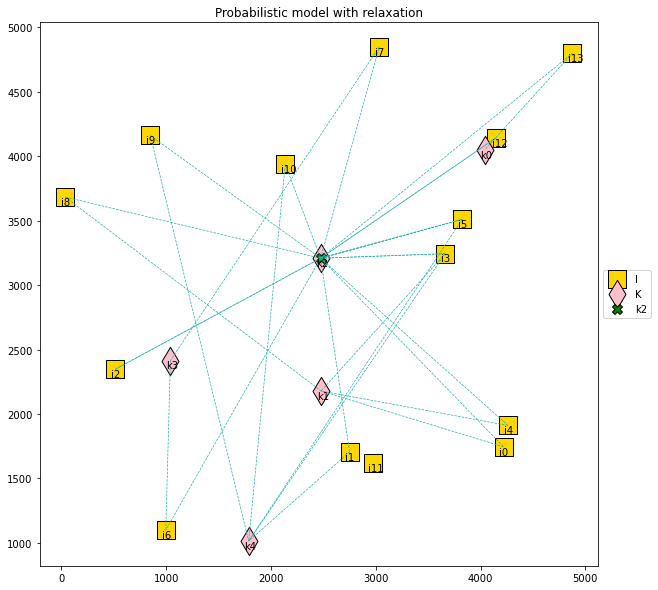

In [ ]:
SolutionGraph(I, K, J, model_prob_rel)

Deterministic model with relaxed constraints

In [ ]:
model_det_rel = gp.Model('Deterministic model with relaxation')

x_ikj = model_det_rel.addVars(I.index, L, vtype = GRB.INTEGER, name = 'x_ikj')
y_j = model_det_rel.addVars(J.index, vtype = GRB.BINARY, name = 'y_j')

In [ ]:
model_det_rel.addConstrs((gp.quicksum(x_ikj[i, k, j] for (k, j) in N_i[i]) >= theta_det[i] for i in I_feas), name = 'c21')
model_det_rel.addConstrs((gp.quicksum(x_ikj[i, k, j] for i in M_kj[(k, j)]) <= q_j[j] * y_j[j] for (k, j) in KJ_feas), name = 'c22')

model_det_rel.addConstrs(((dist_JI[(j, i)] + dist_IK[(i, k)]) * y_j[j] <= B
                  for (k, j) in N_i[i] for i in M_kj[(k, j)]), name = 'c18')

model_det_rel.addConstrs((dist_JI[(j, i)] * y_j[j] <= S for (k, j) in N_i[i] for i in M_kj[(k, j)]), name = 'c25')

model_det_rel.setObjective(alpha * gp.quicksum(x_ikj[i, k, j] for (k, j) in N_i[i] for i in I.index) + gp.quicksum(beta[j] * y_j[j] for j in J.index) + gamma * gp.quicksum((dist_JI[(j, i)] + dist_IK[(i, k)] + dist_KJ[(k, j)]) * y_j[j] for (k, j) in N_i[i] for i in I.index), GRB.MINIMIZE)
model_det_rel.optimize()

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i5-1145G7 @ 2.60GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 13650 rows, 36821 columns and 59660 nonzeros
Model fingerprint: 0x3dbd11f3
Variable types: 0 continuous, 36821 integer (519 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+03]
  Objective range  [2e+04, 4e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 1e+04]
Found heuristic solution: objective 5306820.4185
Presolve removed 11045 rows and 15687 columns
Presolve time: 0.12s
Presolved: 2605 rows, 21134 columns, 43822 nonzeros
Found heuristic solution: objective 506820.41851
Variable types: 0 continuous, 21134 integer (519 binary)

Root relaxation: objective 2.232200e+05, 3046 iterations, 0.29 seconds (0.40 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl | 

In [ ]:
ListSolution(model_det_rel)

Number of solutions found: 3
0
406820 
x_ikj[i0,k4,k2] 9
x_ikj[i1,k4,k2] 11
x_ikj[i2,k4,k2] 4
x_ikj[i3,k3,k2] 2
x_ikj[i4,k4,k2] 5
x_ikj[i5,k4,k2] 11
x_ikj[i6,k1,k2] 4
x_ikj[i7,k3,k2] 48
x_ikj[i8,k1,k2] 8
x_ikj[i9,k1,k2] 12
x_ikj[i9,k4,k2] 3
x_ikj[i10,k4,k2] 7
x_ikj[i12,k1,k2] 26
x_ikj[i12,k2,k2] 50
x_ikj[i13,k0,k2] 7
y_j[k2] 1


1
506820 
x_ikj[i0,k4,k2] 9
x_ikj[i1,k4,k2] 11
x_ikj[i2,k4,k2] 4
x_ikj[i3,k3,k2] 2
x_ikj[i4,k4,k2] 5
x_ikj[i5,k4,k2] 11
x_ikj[i6,k1,k2] 4
x_ikj[i7,k3,k2] 48
x_ikj[i8,k1,k2] 8
x_ikj[i9,k1,k2] 12
x_ikj[i9,k4,k2] 3
x_ikj[i10,k4,k2] 7
x_ikj[i12,k1,k2] 26
x_ikj[i12,k2,k2] 50
x_ikj[i13,k0,k2] 7
y_j[k2] 1


2
5.30682e+06 
x_ikj[i0,k4,k2] 9
x_ikj[i1,k4,k2] 11
x_ikj[i2,k4,k2] 4
x_ikj[i3,k3,k2] 2
x_ikj[i4,k4,k2] 5
x_ikj[i5,k4,k2] 11
x_ikj[i6,k1,k2] 4
x_ikj[i7,k3,k2] 48
x_ikj[i8,k1,k2] 8
x_ikj[i9,k1,k2] 12
x_ikj[i9,k4,k2] 3
x_ikj[i10,k4,k2] 7
x_ikj[i12,k1,k2] 26
x_ikj[i12,k2,k2] 50
x_ikj[i13,k0,k2] 7
y_j[k2] 1






In [ ]:
SolutionSummary(model_det_rel)

(      i  Number of drones
 0    i0                 9
 1    i1                11
 2   i10                 7
 3   i12                76
 4   i13                 7
 5    i2                 4
 6    i3                 2
 7    i4                 5
 8    i5                11
 9    i6                 4
 10   i7                48
 11   i8                 8
 12   i9                15,
     j  Number of drones
 0  k2               207)

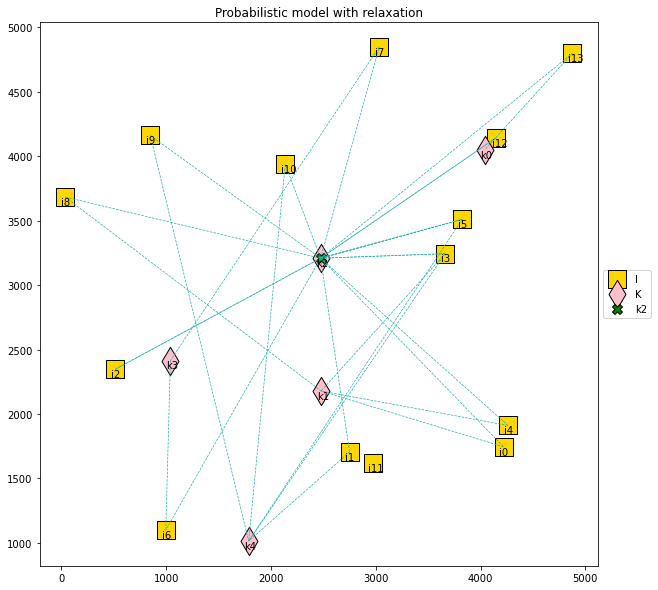

In [ ]:
SolutionGraph(I, K, J, model_prob_rel)

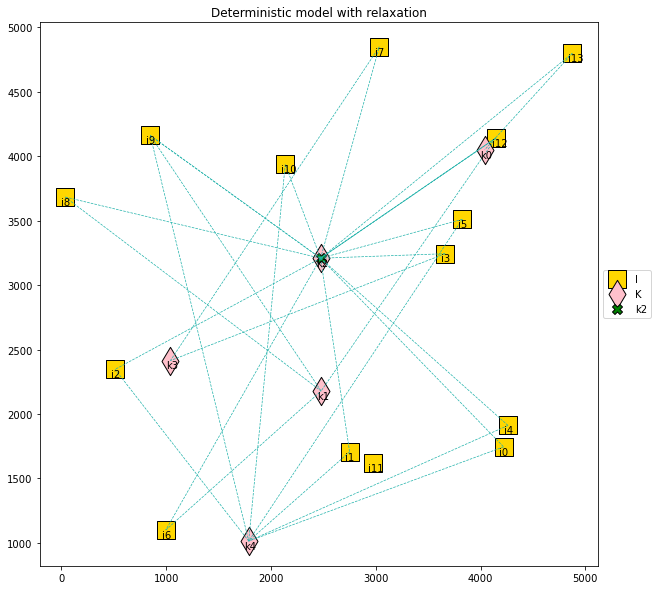

In [ ]:
SolutionGraph(I, K, J, model_det_rel)

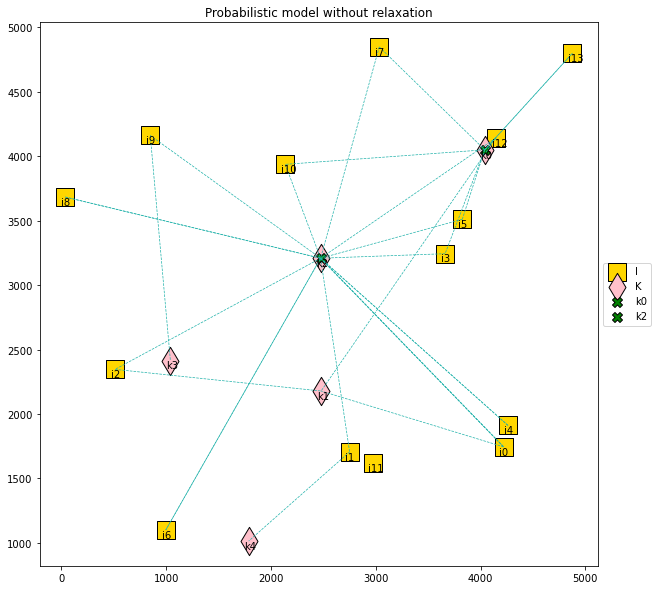

In [ ]:
SolutionGraph(I, K, J, model_prob)

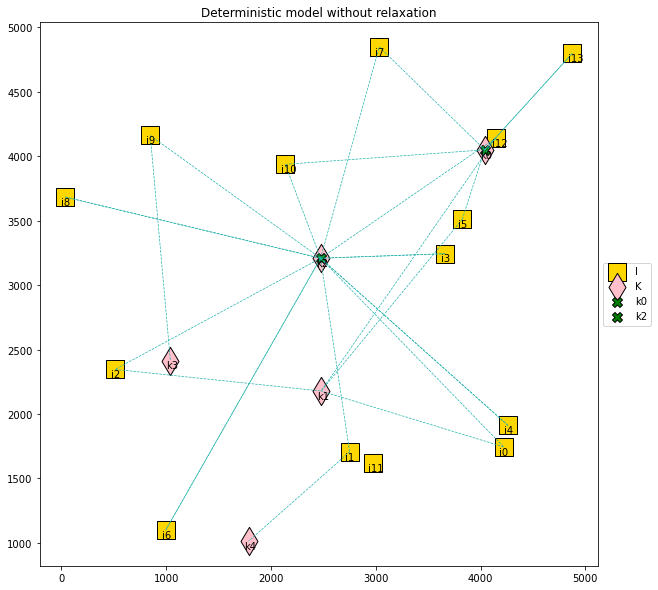

In [ ]:
SolutionGraph(I, K, J, model_det)

1) complete information optimum - lower bound for optimum
2) price of uncertainty